In [1]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas as pd
import xarray
import h5py
import healpy as hp
import time

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting
from ulmo.analysis import spatial_plots as sp

In [2]:
viirs_tbl = ulmo_io.load_main_table( 's3://viirs/Tables/VIIRS_all_99clear_std.parquet')

Read main table: s3://viirs/Tables/VIIRS_all_99clear_std.parquet


In [3]:
viirs_tbl.head()

filename   row   col        lat  \
0  s3://viirs/data/2012/048/20120217193000-OSPO-L...   720  1248  19.590923   
1  s3://viirs/data/2012/047/20120216052000-OSPO-L...  4848  1632 -14.932406   
2  s3://viirs/data/2012/050/20120219111000-OSPO-L...  1008  2112 -36.731842   
3  s3://viirs/data/2012/201/20120719012000-OSPO-L...    48  1056  38.578500   
4  s3://viirs/data/2012/127/20120506022000-OSPO-L...  1488  2016  44.143940   

          lon  clear_fraction  field_size            datetime  \
0   89.338295    4.470527e-17         192 2012-02-17 19:30:00   
1  120.176720    1.898872e-04         192 2012-02-16 05:20:00   
2   33.399803    8.056641e-03         192 2012-02-19 11:10:00   
3    3.368228    4.882812e-04         192 2012-07-19 01:20:00   
4  151.003390    1.220703e-03         192 2012-05-06 02:20:00   

                                         ex_filename  \
0  s3://viirs/Extractions/VIIRS_2012_95clear_192x...   
1  s3://viirs/Extractions/VIIRS_2012_95clear_192x...   
2  s3://viirs/Extractions/VIIRS_2012_95clear_192x...   
3  s3://viirs/Extractions/VIIRS_2012_95clear_192x...   
4  s3://viirs/Extractions/VIIRS_2012_95clear_192x...   

                                             pp_file    pp_root  pp_idx  \
0  s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...  viirs_std       5   
1  s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...  viirs_std       6   
2  s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...  viirs_std       9   
3  s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...  viirs_std      12   
4  s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...  viirs_std      14   

   pp_type  mean_temperature       Tmin       Tmax        T90        T10  \
0        0         24.843233  24.029999  25.730011  25.119995  24.510010   
1        0         31.347763  29.929993  31.869995  31.579987  31.119995   
2        0         22.753841  20.970001  23.489990  23.089996  22.429993   
3        0         25.789021  23.619995  26.589996  26.139984  25.420013   
4        0          4.603452   3.470001   5.579987   5.059998   4.109985   

           LL  Year  
0  331.460999  2012  
1  579.588074  2012  
2  274.181274  2012  
3  266.262878  2012  
4   65.829651  2012

# Functions

In [4]:
def show_spatial_two_avg(tbl1:pd.DataFrame, tbl2:pd.DataFrame, 
                 nside=64, use_log=True, 
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='coolwarm', show=True):
    """Generate a global map of the location of the input
    cutouts

    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True

    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events1, hp_lons1, hp_lats1, hp_values1 = sp.evals_to_healpix(
        tbl1, nside, log=use_log, mask=use_mask)
    
    hp_events2, hp_lons2, hp_lats2, hp_values2 = sp.evals_to_healpix(
        tbl2, nside, log=use_log, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()

    tformM = ccrs.Mollweide()
    tformP = ccrs.PlateCarree()

    ax = plt.axes(projection=tformM)

    if tricontour:
        cm = plt.get_cmap(color)
        img = ax.tricontourf(hp_lons1, hp_lats1, hp_values1 - hp_values2, transform=tformM,
                         levels=20, cmap=cm)#, zorder=10)
    else:
        cm = plt.get_cmap(color)
        # Cut
        good = np.invert(hp_values2.mask)
        img = plt.scatter(x=hp_lons2[good],
            y=hp_lats2[good],
            c=hp_values1[good]- hp_values2[good], vmin = -300, vmax = 300, 
            cmap=cm,
            s=1,
            transform=tformP)

    # Colorbar
    cb = plt.colorbar(img, orientation='horizontal', pad=0.)
    if lbl is not None:
        #clbl=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl)+'}$'
        clbl = 'diff_mean_LL'
        cb.set_label(clbl, fontsize=20.)
    cb.ax.tick_params(labelsize=17)

    # Coast lines
    if not tricontour:
        ax.coastlines(zorder=10)
        ax.set_global()
    
        gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
            color='black', alpha=0.5, linestyle=':', draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right=False
        gl.xlines = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'black'}# 'weight': 'bold'}
        gl.ylabel_style = {'color': 'black'}# 'weight': 'bold'}
        #gl.xlocator = mticker.FixedLocator([-180., -160, -140, -120, -60, -20.])
        #gl.xlocator = mticker.FixedLocator([-240., -180., -120, -65, -60, -55, 0, 60, 120.])
        #gl.ylocator = mticker.FixedLocator([0., 15., 30., 45, 60.])


    # Layout and save
    if show:
        plt.show()

    return ax

In [5]:
def show_spatial_two_med(tbl1:pd.DataFrame, tbl2:pd.DataFrame, 
                 nside=64, 
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='coolwarm', show=True):
    """Generate a global map of the location of the input
    cutouts

    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True

    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events1, hp_lons1, hp_lats1, hp_values1 = sp.evals_to_healpix_meds(
        tbl1, nside, mask=use_mask)
    
    hp_events2, hp_lons2, hp_lats2, hp_values2 = sp.evals_to_healpix_meds(
        tbl2, nside, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()

    tformM = ccrs.Mollweide()
    tformP = ccrs.PlateCarree()

    ax = plt.axes(projection=tformM)

    if tricontour:
        cm = plt.get_cmap(color)
        img = ax.tricontourf(hp_lons1, hp_lats1, hp_values1 - hp_values2, transform=tformM,
                         levels=20, cmap=cm)#, zorder=10)
    else:
        cm = plt.get_cmap(color)
        # Cut
        good = np.invert(hp_values2.mask)
        img = plt.scatter(x=hp_lons2[good],
            y=hp_lats2[good],
            c=hp_values1[good]- hp_values2[good], vmin = -300, vmax = 300, 
            cmap=cm,
            s=1,
            transform=tformP)

    # Colorbar
    cb = plt.colorbar(img, orientation='horizontal', pad=0.)
    if lbl is not None:
        #clbl=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl)+'}$'
        clbl = r'$LL_{VIIRS} - LL_{LLC}$'
        cb.set_label(clbl, fontsize=20.)
    cb.ax.tick_params(labelsize=17)

    # Coast lines
    if not tricontour:
        ax.coastlines(zorder=10)
        ax.set_global()
    
        gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
            color='black', alpha=0.5, linestyle=':', draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right=False
        gl.xlines = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'black'}# 'weight': 'bold'}
        gl.ylabel_style = {'color': 'black'}# 'weight': 'bold'}
        #gl.xlocator = mticker.FixedLocator([-180., -160, -140, -120, -60, -20.])
        #gl.xlocator = mticker.FixedLocator([-240., -180., -120, -65, -60, -55, 0, 60, 120.])
        #gl.ylocator = mticker.FixedLocator([0., 15., 30., 45, 60.])

        plt.savefig('med_LL_diff_VIIRS_vs_LLC', dpi = 300)

    # Layout and save
    if show:
        plt.show()

    return ax

In [6]:
def scatter_diff_avg(tbl1:pd.DataFrame, tbl2:pd.DataFrame, 
                 nside=32, use_log=False, 
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='plasma', show=True):
    """Generate a scatter plot with the difference of mean LL between two
    dataframes (pixel-wise) as a function of the number of cutouts

    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True

    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events1, hp_lons1, hp_lats1, hp_values1 = sp.evals_to_healpix(
        tbl1, nside, log=use_log, mask=use_mask)
    
    hp_events2, hp_lons2, hp_lats2, hp_values2 = sp.evals_to_healpix(
        tbl2, nside, log=use_log, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()
    cm = plt.get_cmap(color)
        
    # Cut
    good = np.invert(hp_values2.mask)
    ax = plt.scatter(x= hp_events2[good] , y = hp_values1[good]- hp_values2[good], s=1)

    # Colorbar
    #cb = plt.colorbar(ax, orientation='vertical', pad=0.1)
    #if lbl is not None:
        #clbl=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl)+'}$'
    #    clbl = 'diff_mean_LL'
    #    cb.set_label(clbl, fontsize=20.)
    #cb.ax.tick_params(labelsize=17)

    # Axis Labels
    plt.xlabel('num of cutouts : table 2')
    plt.ylabel('diff_mean_LL')
    plt.ylim(-1000, 1000)


    # Layout and save
    if show:
        plt.show()

    return ax

In [7]:
def scatter_diff_med(tbl1:pd.DataFrame, tbl2:pd.DataFrame, 
                 nside=64,  
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='plasma', show=True):
    """Generate a scatter plot with the difference of mean LL between two
    dataframes (pixel-wise) as a function of the number of cutouts

    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True

    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events1, hp_lons1, hp_lats1, hp_values1 = sp.evals_to_healpix_meds(
        tbl1, nside, mask=use_mask)
    
    hp_events2, hp_lons2, hp_lats2, hp_values2 = sp.evals_to_healpix_meds(
        tbl2, nside, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()
    cm = plt.get_cmap(color)
        
    # Cut
    a = hp_values1.mask == False
    b = hp_values2.mask == False
    c = a & (a==b)
    
    ax = plt.scatter(x= hp_events1[c] , y = hp_values1[c]- hp_values2[c], s=1)

    # Colorbar
    #cb = plt.colorbar(ax, orientation='vertical', pad=0.1)
    #if lbl is not None:
        #clbl=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl)+'}$'
    #    clbl = 'diff_mean_LL'
    #    cb.set_label(clbl, fontsize=20.)
    #cb.ax.tick_params(labelsize=17)

    # Axis Labels
    plt.xlabel('# of satellite cutouts in bin', fontsize = 20)
    plt.ylabel(r'$LL_{VIIRS} - LL_{LLC}$', fontsize = 20)
    plt.ylim(-1000, 1000)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig('Variability_med_LL_diff_VIIRS_vs_LLC', dpi = 300)
    


    # Layout and save
    if show:
        plt.show()

    return ax

# Check for a temporal trend

## 2012 to 2015

In [11]:
viirs_head = viirs_tbl[ (viirs_tbl.datetime.dt.year > 2011) & (viirs_tbl.datetime.dt.year < 2015) ]
viirs_head.shape

(738358, 19)

## 2018 to 2020

In [12]:
viirs_tail = viirs_tbl[ (viirs_tbl.datetime.dt.year > 2017) & (viirs_tbl.datetime.dt.year < 2021) ]
viirs_tail.shape

(801446, 19)

### Show avg LL 

/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


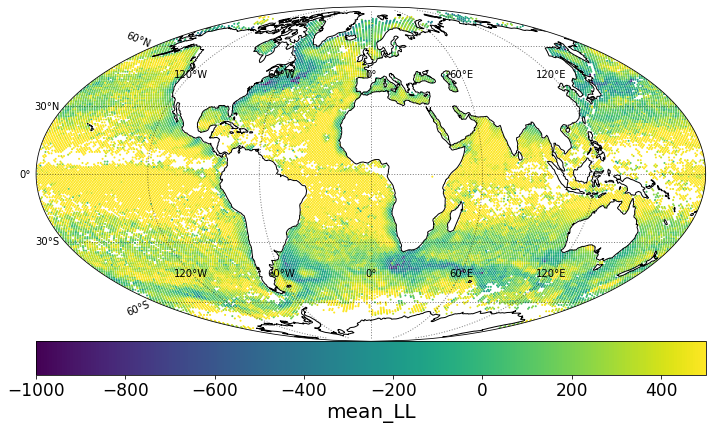

In [20]:
_ = sp.show_med_LL(viirs_head, lbl = True)

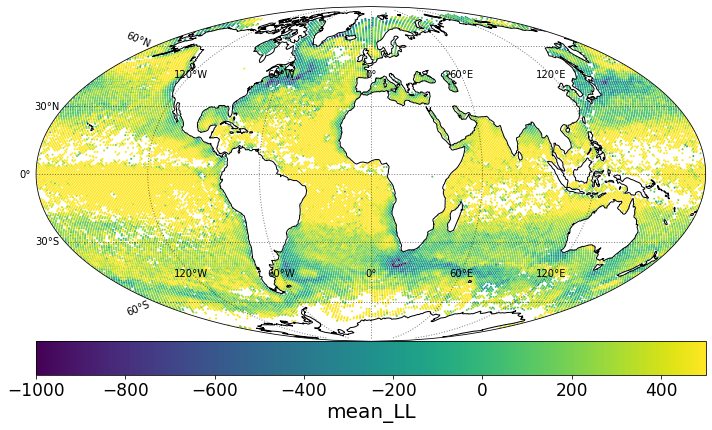

In [21]:
_ = sp.show_med_LL(viirs_tail, lbl = True)

### Show diff in avg LL

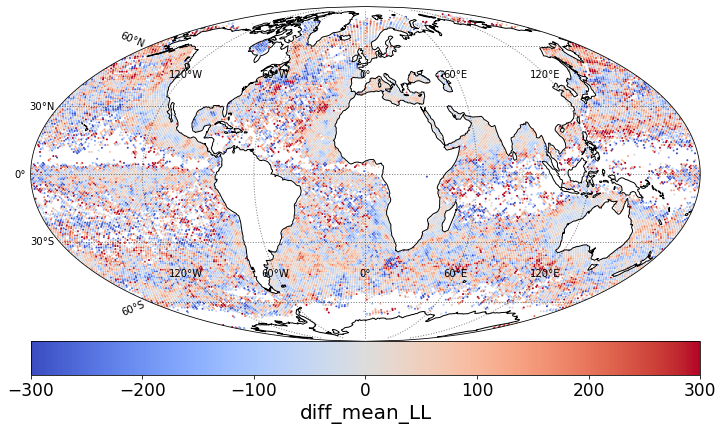

<GeoAxesSubplot:>

In [24]:
show_spatial_two_med(viirs_tail, viirs_head, lbl=True)

## Scatter diff

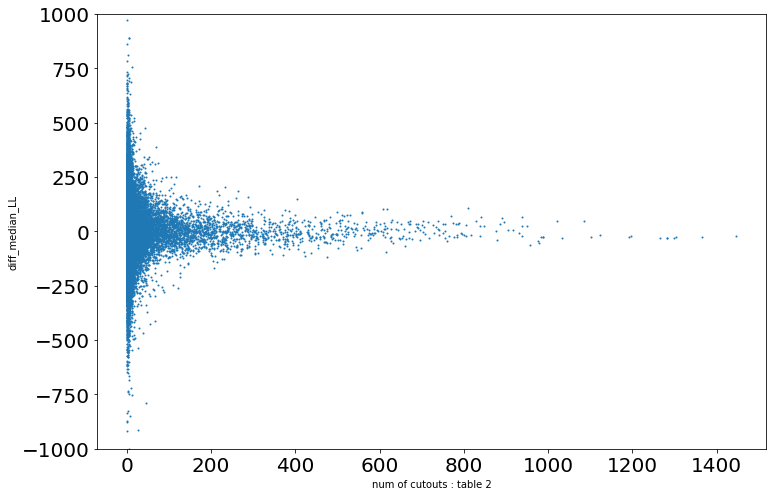

In [14]:
scatter_diff_med(viirs_tail, viirs_head, lbl = True)

In [112]:
NSIDE = 32
print("Approximate resolution at NSIDE {} is {:.2} deg".format(NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60))

Approximate resolution at NSIDE 32 is 1.8 deg


In [87]:
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

12288


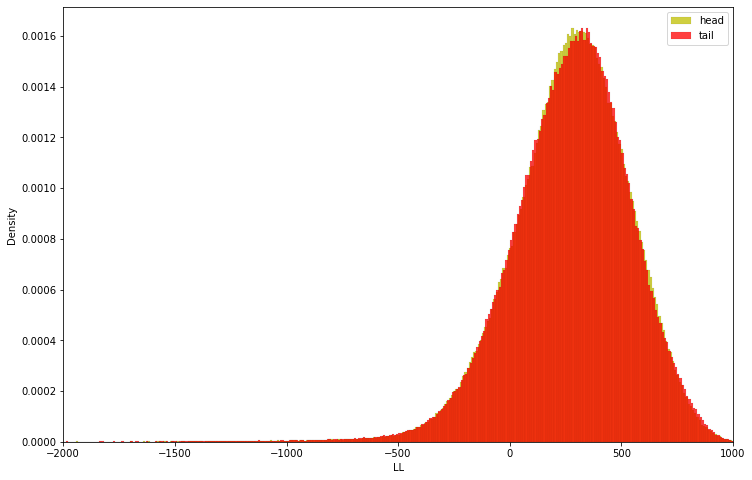

In [40]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
_ = sns.histplot(viirs_tail, x='LL', ax=ax, binwidth = 10, color = 'y', stat ='density', label = 'head')
_ = sns.histplot(viirs_head, x='LL', ax=ax, binwidth = 10, color = 'r', stat ='density', label = 'tail')
ax.set_xlim(-2000., 1000.)
ax.legend()

# VIIRS: all years vs LLC (w/ noise)

### Load table

In [8]:
tbl_file = 's3://llc/Tables/LLC_uniform_viirs_noise.parquet'
llc_tbl = ulmo_io.load_main_table( tbl_file )

Read main table: s3://llc/Tables/LLC_uniform_viirs_noise.parquet


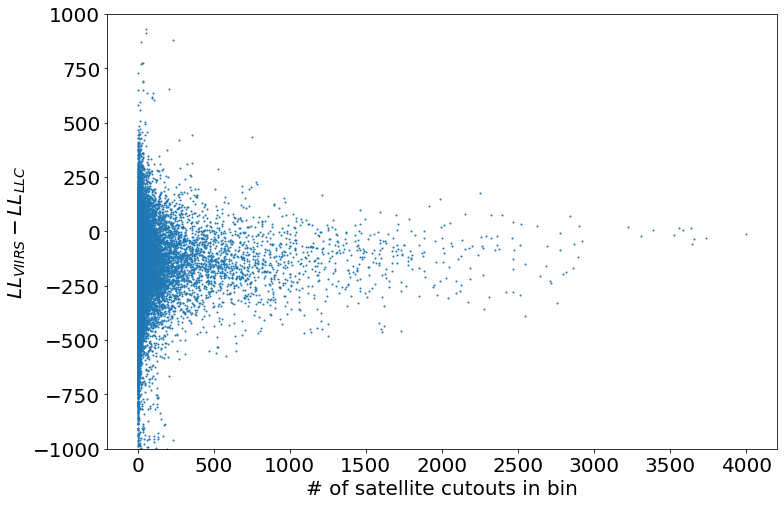

In [18]:
scatter_diff_med( viirs_tbl, llc_tbl)

In [16]:
pwd

'/home/jovyan/ulmo/ulmo/notebooks'

### Diff in median LL

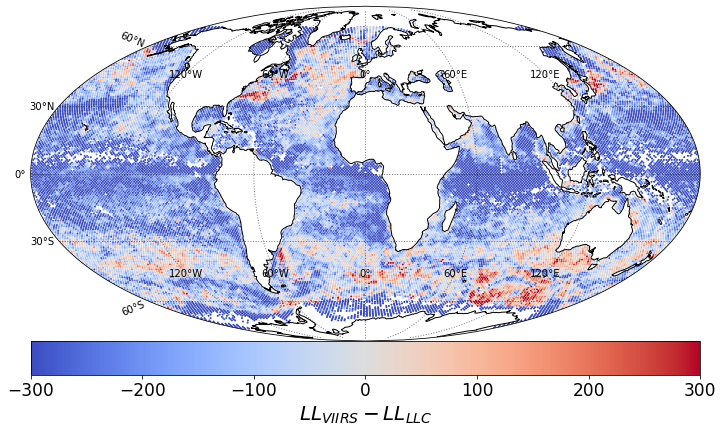

<GeoAxesSubplot:>

In [24]:
show_spatial_two_med(viirs_tbl, llc_tbl, lbl=True)

### Show median LL for LLC w/ viirs noise

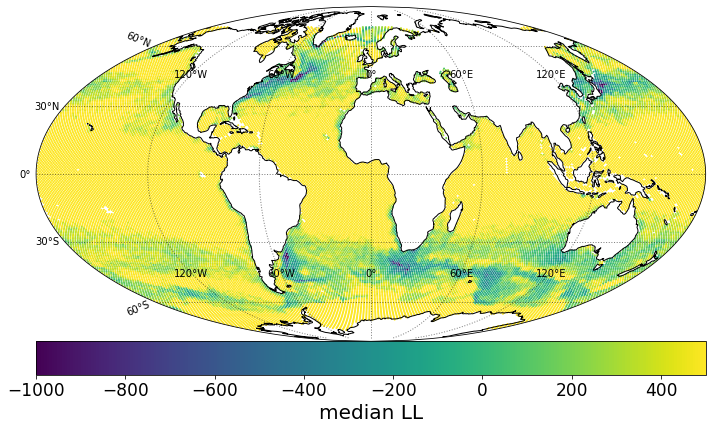

<GeoAxesSubplot:>

In [25]:
sp.show_med_LL(llc_tbl, lbl=True)

### Show median LL for VIIRS: all years

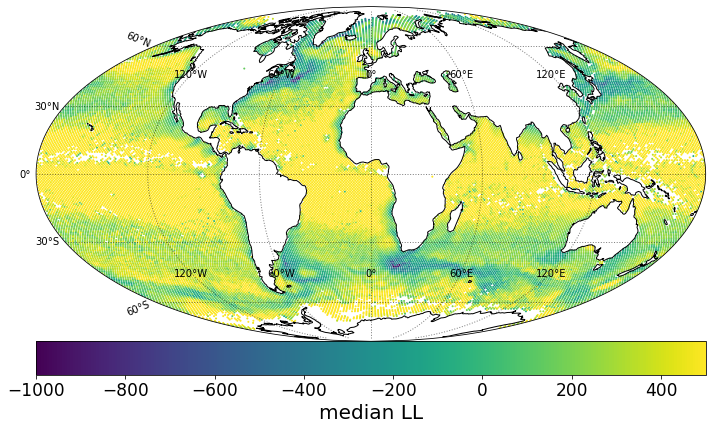

<GeoAxesSubplot:>

In [26]:
sp.show_med_LL(viirs_tbl, lbl=True)

# Coverage

/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


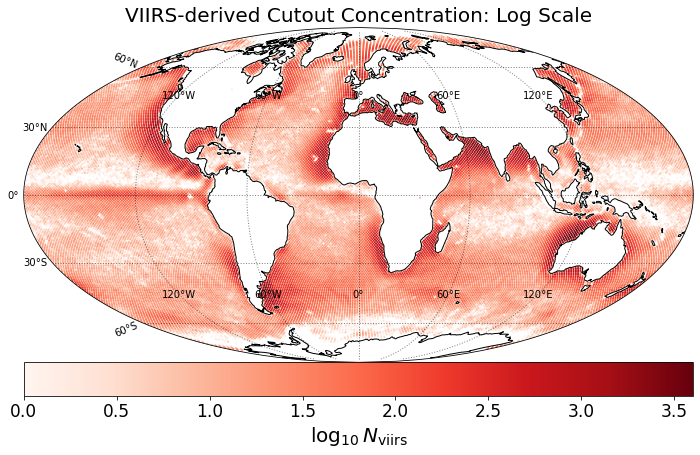

In [3]:
_ = ulmo_figs.show_spatial(viirs_tbl, lbl = 'viirs')

/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


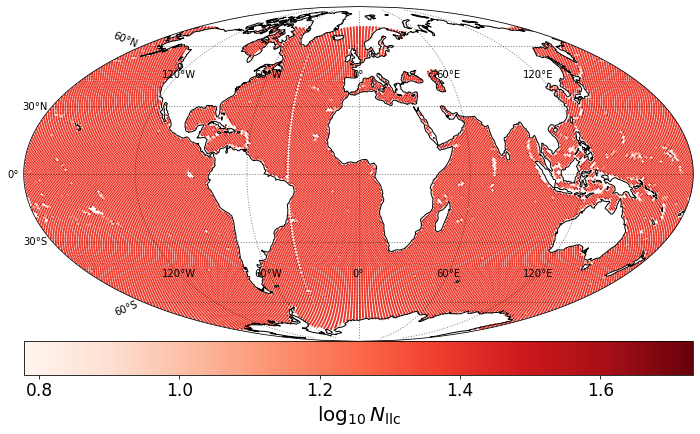

In [23]:
_ = ulmo_figs.show_spatial(llc_tbl, lbl = 'llc')

# LL Histogram

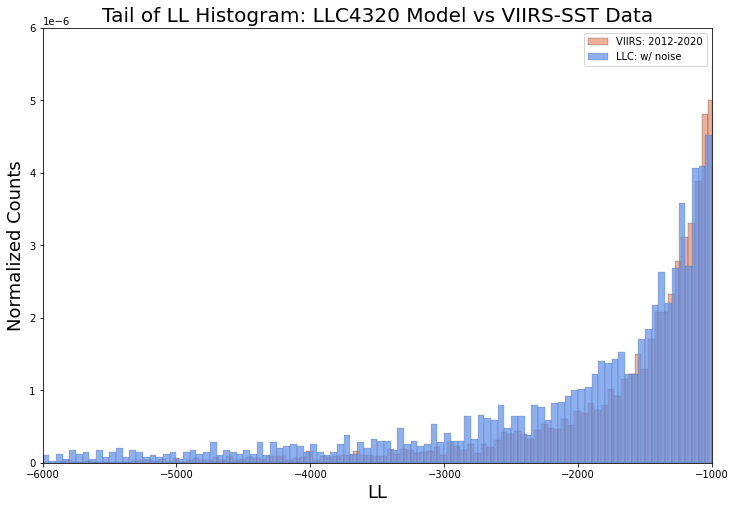

In [21]:
# Give histplot the dataframe and the column name
fig = plt.figure(figsize=(12,8))
ax1 = plt.gca()
ax1 = sns.histplot(data=viirs_tbl, x='LL', color = 'darksalmon', stat = 'density', binwidth=50, label = 'VIIRS: 2012-2020')
ax1 = sns.histplot(data=llc_tbl, x='LL', color = 'cornflowerblue', stat = 'density', binwidth=50,label = 'LLC: w/ noise')

ax1.set_xlim(-6000., -1000)
ax1.set_ylim(0, 0.000006)
ax1.set_xlabel('LL', fontsize = 18)
ax1.set_ylabel('Normalized Counts', fontsize = 18)
ax1.set_title('Tail of LL Histogram: LLC4320 Model vs VIIRS-SST Data', fontsize =20)
ax1.legend()

plt.savefig('LL_Hist_LLC_VIIRS_tail', dpi=300)

In [18]:
llc_uniform= ulmo_io.load_main_table( 's3://llc/Tables/test_uniform_r0.5_test.feather' )
llc_uniform.head()

Read main table: s3://llc/Tables/test_uniform_r0.5_test.feather


lat         lon    row    col   datetime  \
0  71.725098 -177.172684  12895  10607 2011-09-30   
1  71.747978 -175.380554  12895  10676 2011-09-30   
2  71.758400 -173.559555  12895  10746 2011-09-30   
3  71.755905 -171.737854  12895  10816 2011-09-30   
4  71.740822 -169.943695  12895  10885 2011-09-30   

                                            LLC_file  \
0  s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...   
1  s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...   
2  s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...   
3  s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...   
4  s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...   

                                        pp_file  pp_root  field_size  \
0  s3://llc/PreProc/LLC_uniform_test_preproc.h5  llc_std          64   
1  s3://llc/PreProc/LLC_uniform_test_preproc.h5  llc_std          64   
2  s3://llc/PreProc/LLC_uniform_test_preproc.h5  llc_std          64   
3  s3://llc/PreProc/LLC_uniform_test_preproc.h5  llc_std          64   
4  s3://llc/PreProc/LLC_uniform_test_preproc.h5  llc_std          64   

   mean_temperature  ...       T10  pp_idx  pp_type          LL    U_mean  \
0         -1.467546  ... -1.541000  647491        0  648.981934 -0.099179   
1         -0.492408  ... -1.540001  384768        0 -513.771851 -0.008606   
2          3.271719  ...  2.540999  283882        0  345.448669  0.070156   
3          2.945127  ...  2.229000  613023        0  169.709839  0.081717   
4          2.364319  ...  1.891000  537161        0  349.981262  0.039346   

     V_mean     U_rms     V_rms   UV_mean    UV_rms  
0 -0.001986  0.059771  0.063255  0.141285  0.082805  
1 -0.042140  0.041484  0.108360  0.046431  0.037870  
2 -0.045817  0.022577  0.044823  0.099820  0.029986  
3 -0.010355  0.024675  0.039160  0.115622  0.034708  
4  0.019852  0.023803  0.031211  0.057416  0.030541  

[5 rows x 23 columns]

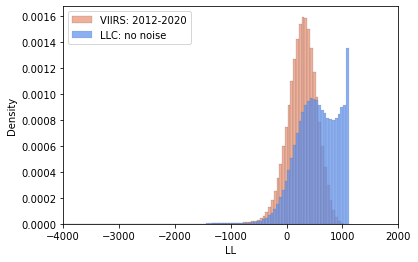

In [22]:
# Give histplot the dataframe and the column name
ax1 = sns.histplot(data=viirs_tbl, x='LL', color = 'darksalmon', stat = 'density', binwidth=50, label = 'VIIRS: 2012-2020')
ax1 = sns.histplot(data=llc_uniform, x='LL', color = 'cornflowerblue', stat = 'density', binwidth=50,label = 'LLC: no noise')

ax1.set_xlim(-4000., 2000.)
#ax1.set_ylim(0., 0.01)
ax1.legend()

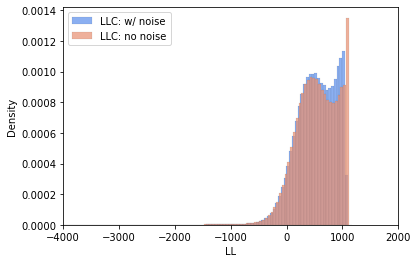

In [21]:
# Give histplot the dataframe and the column name
ax1 = sns.histplot(data=llc_tbl, x='LL', color = 'cornflowerblue', stat = 'density', binwidth=50, label = 'LLC: w/ noise')
ax1 = sns.histplot(data=llc_uniform, x='LL', color = 'darksalmon', stat = 'density', binwidth=50,label = 'LLC: no noise')

ax1.set_xlim(-4000., 2000.)
#ax1.set_ylim(0., 0.01)
ax1.legend()

# Create h5 file: with wanted cutouts

### Create subroutine for 1 pp_file (one year)

In [19]:
file_list = pd.unique( viirs_tbl.pp_file)

In [20]:
viirs_tbl.shape[0]

2291591

In [21]:
file = file_list[1]
file

's3://viirs/PreProc/VIIRS_2013_95clear_192x192_preproc_viirs_std.h5'

In [22]:
sub_tbl = viirs_tbl[ file == viirs_tbl.pp_file ]
sub_tbl.shape[0]

258998

In [23]:
index_list = sub_tbl.pp_idx.sort_values()
index_list

243800          7
453874          8
257601         16
377538         18
319716         26
           ...   
278733    1123928
288904    1123929
262243    1123932
273135    1123934
266731    1123969
Name: pp_idx, Length: 258998, dtype: int64

In [2]:
chunk_list = np.arange(0, sub_tbl.shape[0], 10000 )
chunk_list.shape[0]

NameError: name 'np' is not defined

In [25]:
index_list[0:10000].to_numpy().shape

(10000,)

In [26]:
#BIG NO NO
# initialize image matrix
cutouts = np.ndarray( (viirs_tbl.shape[0], 1, 64, 64) )

In [27]:
count = 231905

In [ ]:
count

In [1]:
for chunk in chunk_list: 
    
    if sub_tbl.shape[0] - chunk >= 10000: 
        
        # grab indices
        idxs = index_list[chunk: chunk + 10000].to_numpy()
        
        # grab cutouts
        with h5py.File('/home/jovyan/VIIRS_2017_95clear_192x192_preproc_viirs_std.h5') as f: 
            
            imgs = f['valid'][idxs, 0, ...]
            
        # save cutouts in an array
        marker = count + chunk  
        cutouts[marker: marker + 10000, 0, ...] = imgs
        
    else: 
        
        # grab indices
        idxs = index_list[chunk: sub_tbl.shape[0]].to_numpy()
        
        # grab cutouts
        with h5py.File('/home/jovyan/VIIRS_2017_95clear_192x192_preproc_viirs_std.h5') as f: 
            
            imgs = f['valid'][idxs, 0, ...]
            
        # save cutouts in an array
        marker = count + chunk 
        diff = sub_tbl.shape[0] - chunk
        cutouts[marker: marker + diff, 0, ...] = imgs
        
        count += sub_tbl.shape[0]

NameError: name 'chunk_list' is not defined

In [32]:
cutouts[231905, 0, ...]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
with h5py.File( '/home/jovyan/VIIRS_all_99clear_192x192_preproc.h5', 'w') as g:
    
    g.create_dataset( name='2012', data = cutouts[0:sub_tbl.shape[0], 0, ...])
